In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.compat.v1.train import AdamOptimizer

In [24]:
tf.__version__

'2.15.0'

In [25]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [26]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train_images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 10407 files belonging to 10 classes.


In [27]:
print(dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [28]:
class_names = dataset.class_names
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [29]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    print(len(labels_batch.numpy()))

(32, 256, 256, 3)
[5 4 5 9 9 3 0 5 7 4 3 4 0 3 6 8 8 9 9 4 5 2 2 5 9 8 5 7 6 8 5 4]
32


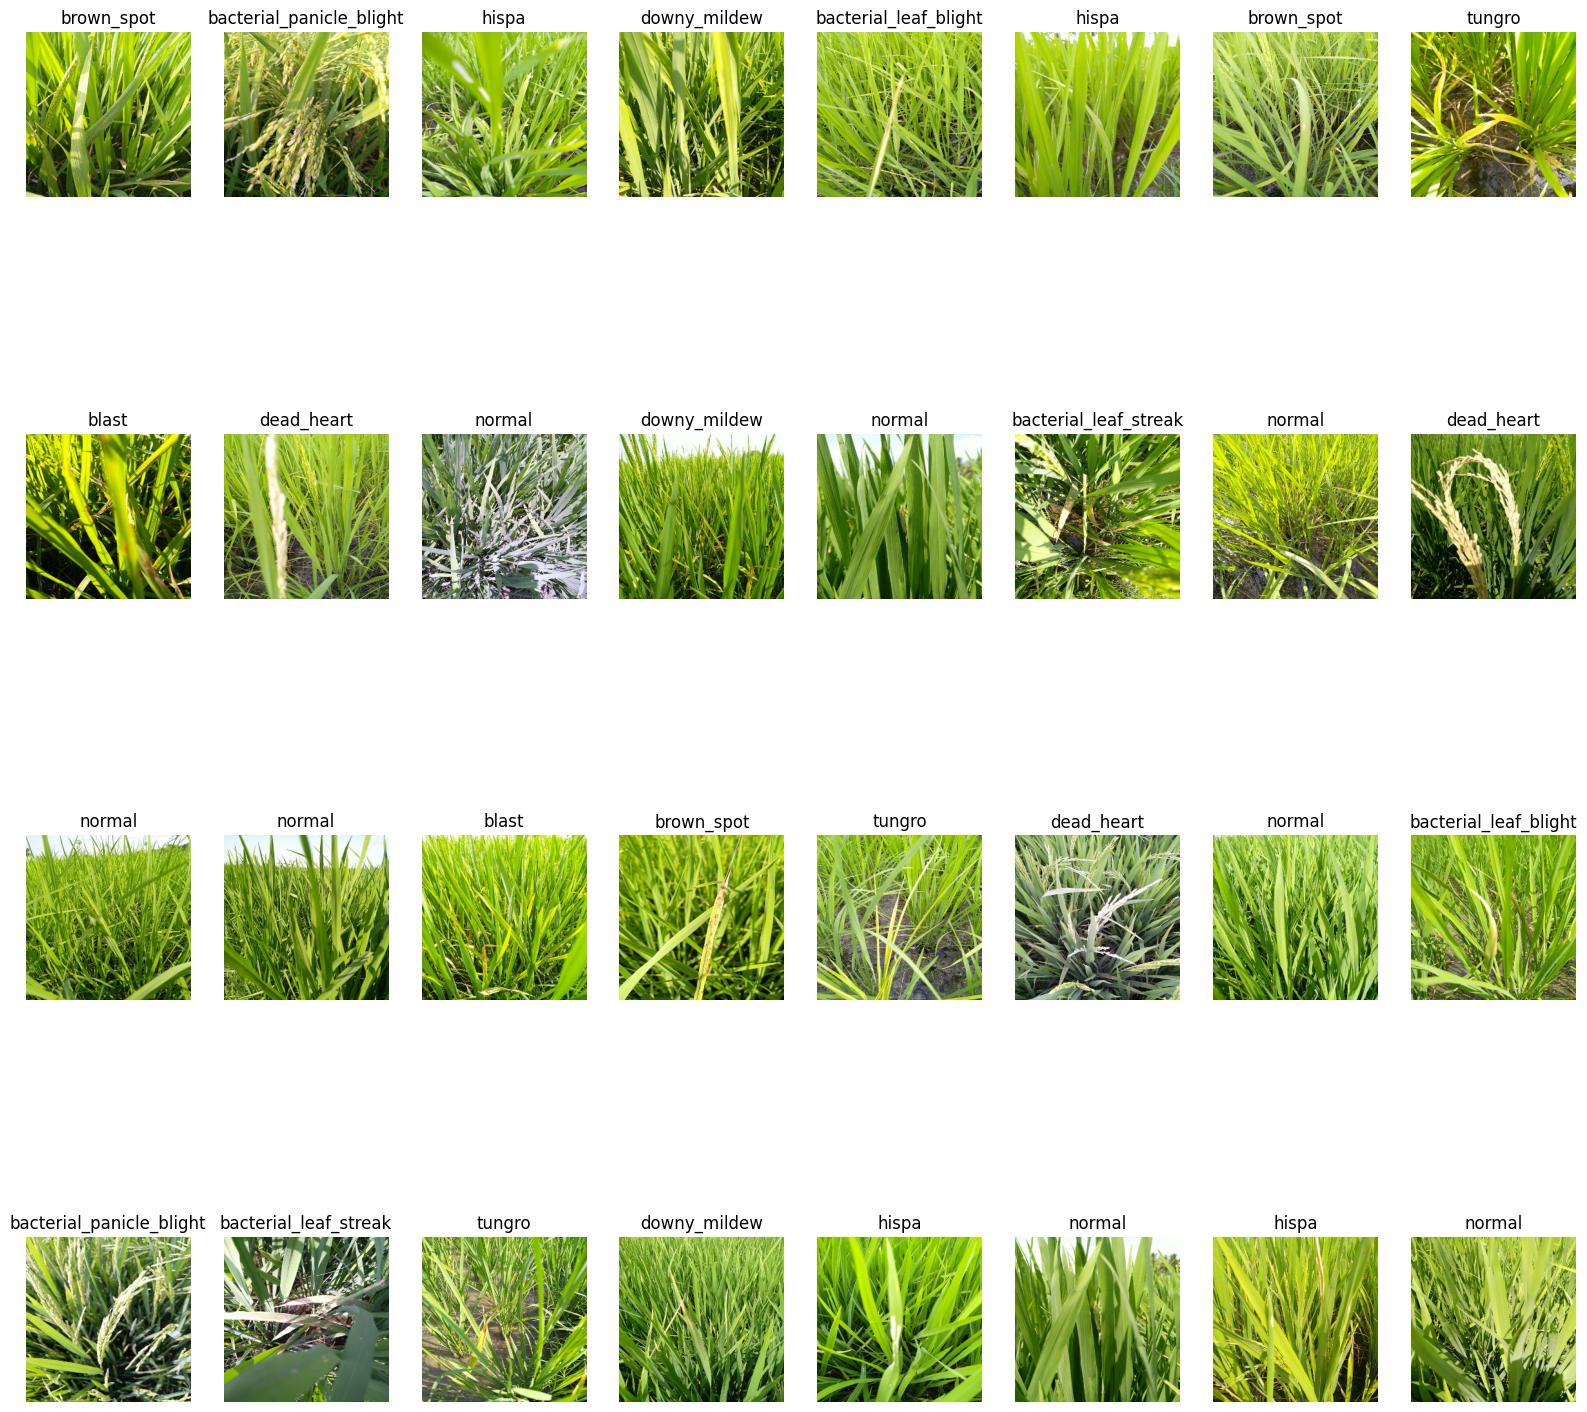

In [30]:
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [31]:
len(dataset)

326

In [32]:
326*32

10432

In [33]:
len(dataset)

326

In [34]:
train_size = 0.8
len(dataset)*train_size

260.8

In [35]:
train_ds = dataset.take(261)
len(train_ds)

261

In [36]:
rem_ds = dataset.skip(261)
len(rem_ds)

65

In [37]:
val_ds = rem_ds.take(30)
len(val_ds)

30

In [38]:
test_ds = rem_ds.skip(30)
len(test_ds)

35

In [39]:
print("train dataset", train_ds)

train dataset <_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [40]:
print("validation dataset", val_ds)

validation dataset <_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [41]:
print("test dataset", test_ds)

test dataset <_SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## Cache, Shuffle and Prefetch Datasets

In [42]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch[0].numpy())
    print(len(image_batch[0].numpy()))

[[[138.0625   178.07812    3.515625]
  [110.75     131.46875    4.0625  ]
  [130.25     136.65625   30.890625]
  ...
  [118.625    159.0625     5.203125]
  [120.3125   167.375      0.3125  ]
  [120.953125 169.95312    2.25    ]]

 [[150.95312  181.78125   19.625   ]
  [118.59375  135.89062    8.71875 ]
  [125.0625   132.54688   25.234375]
  ...
  [120.78125  161.42188    2.3125  ]
  [121.71875  168.85938    0.34375 ]
  [121.890625 170.89062    1.6875  ]]

 [[186.20312  205.48438   65.90625 ]
  [124.109375 139.0625    13.65625 ]
  [116.703125 129.1875    14.46875 ]
  ...
  [123.453125 164.70312    4.46875 ]
  [123.640625 171.01562    2.578125]
  [123.09375  172.09375    3.9375  ]]

 ...

 [[166.21875  181.51562   10.75    ]
  [164.17188  180.48438   12.9375  ]
  [162.4375   180.5625    20.546875]
  ...
  [130.48438  160.48438   60.859375]
  [142.70312  173.39062   71.328125]
  [115.3125   146.45312   42.359375]]

 [[165.57812  185.375      3.03125 ]
  [161.03125  181.07812    7.359375]


## Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

Resizing the image into 256x256 will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [44]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation for better accuracy

In [50]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [76]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (4,4), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (4,4), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size = (4,4), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (4, 4), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (4, 4), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (4, 4), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [78]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_48 (Conv2D)          (32, 253, 253, 32)        1568      
                                                                 
 max_pooling2d_48 (MaxPooli  (32, 126, 126, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (32, 123, 123, 64)        32832     
                                                                 
 max_pooling2d_49 (MaxPooli  (32, 61, 61, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (32, 58, 58, 128)       

## Compiling the model using 'adam' optimizer and SparseCategoricalCrossEntroy

In [81]:
from tensorflow.keras import metrics

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [82]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
261/261 [==============================] - 604s 2s/step - loss: 2.1534 - accuracy: 0.1881 - val_loss: 1.9995 - val_accuracy: 0.2875
Epoch 2/20
261/261 [==============================] - 533s 2s/step - loss: 1.8113 - accuracy: 0.3709 - val_loss: 1.7867 - val_accuracy: 0.3896
Epoch 3/20
261/261 [==============================] - 531s 2s/step - loss: 1.5498 - accuracy: 0.4685 - val_loss: 1.4397 - val_accuracy: 0.5042
Epoch 4/20
261/261 [==============================] - 580s 2s/step - loss: 1.2635 - accuracy: 0.5764 - val_loss: 1.2466 - val_accuracy: 0.6052
Epoch 5/20
261/261 [==============================] - 511s 2s/step - loss: 0.9838 - accuracy: 0.6786 - val_loss: 1.0086 - val_accuracy: 0.6667
Epoch 6/20
261/261 [==============================] - 560s 2s/step - loss: 0.7367 - accuracy: 0.7602 - val_loss: 0.9427 - val_accuracy: 0.7073
Epoch 7/20
261/261 [==============================] - 506s 2s/step - loss: 0.5531 - accuracy: 0.8259 - val_loss: 0.8672 - val_accuracy: 0.7531

In [83]:
scores = model.evaluate(test_ds)

35/35 [==============================] - 26s 415ms/step - loss: 0.8061 - accuracy: 0.8712


In [84]:
scores

[0.8060538172721863, 0.8712328672409058]

In [85]:
history

In [86]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 261}

In [87]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [88]:
type(history.history['loss'])

list

In [89]:
len(history.history['loss'])

20

In [90]:
history.history['loss'][:5]

[2.1534478664398193,
 1.8113410472869873,
 1.549768328666687,
 1.2634661197662354,
 0.9838115572929382]

In [91]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


Text(0.5, 1.0, 'Training and Validation Loss')

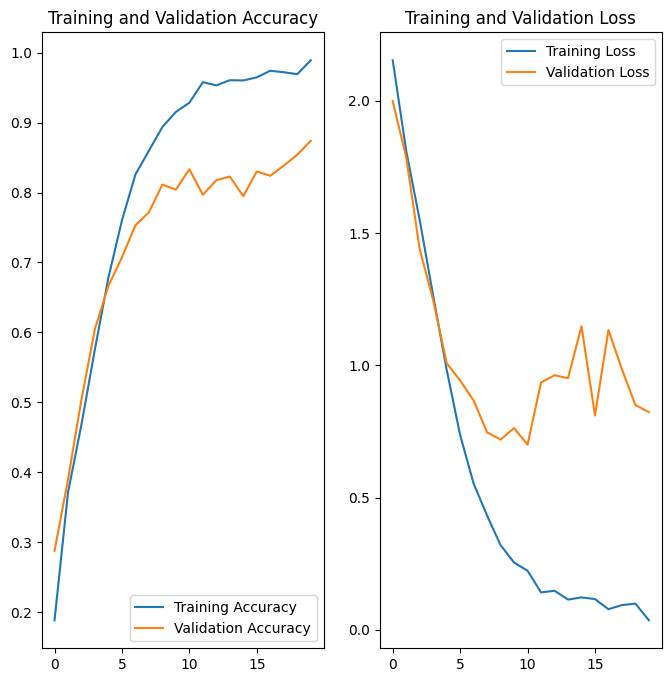

In [92]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

First image to predict
Actual Label:  hispa
1/1 [==============================] - 1s 736ms/step
Predicted Label : normal


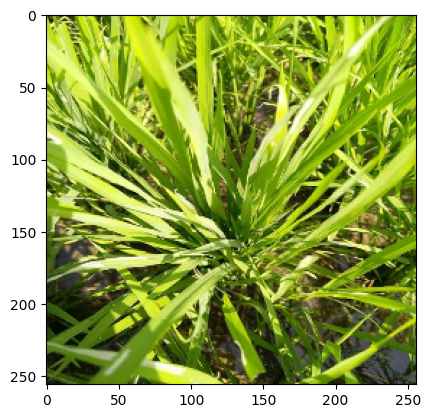

In [93]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label: ", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted Label :", class_names[np.argmax(batch_prediction[0])])

## Function for Inference

In [94]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


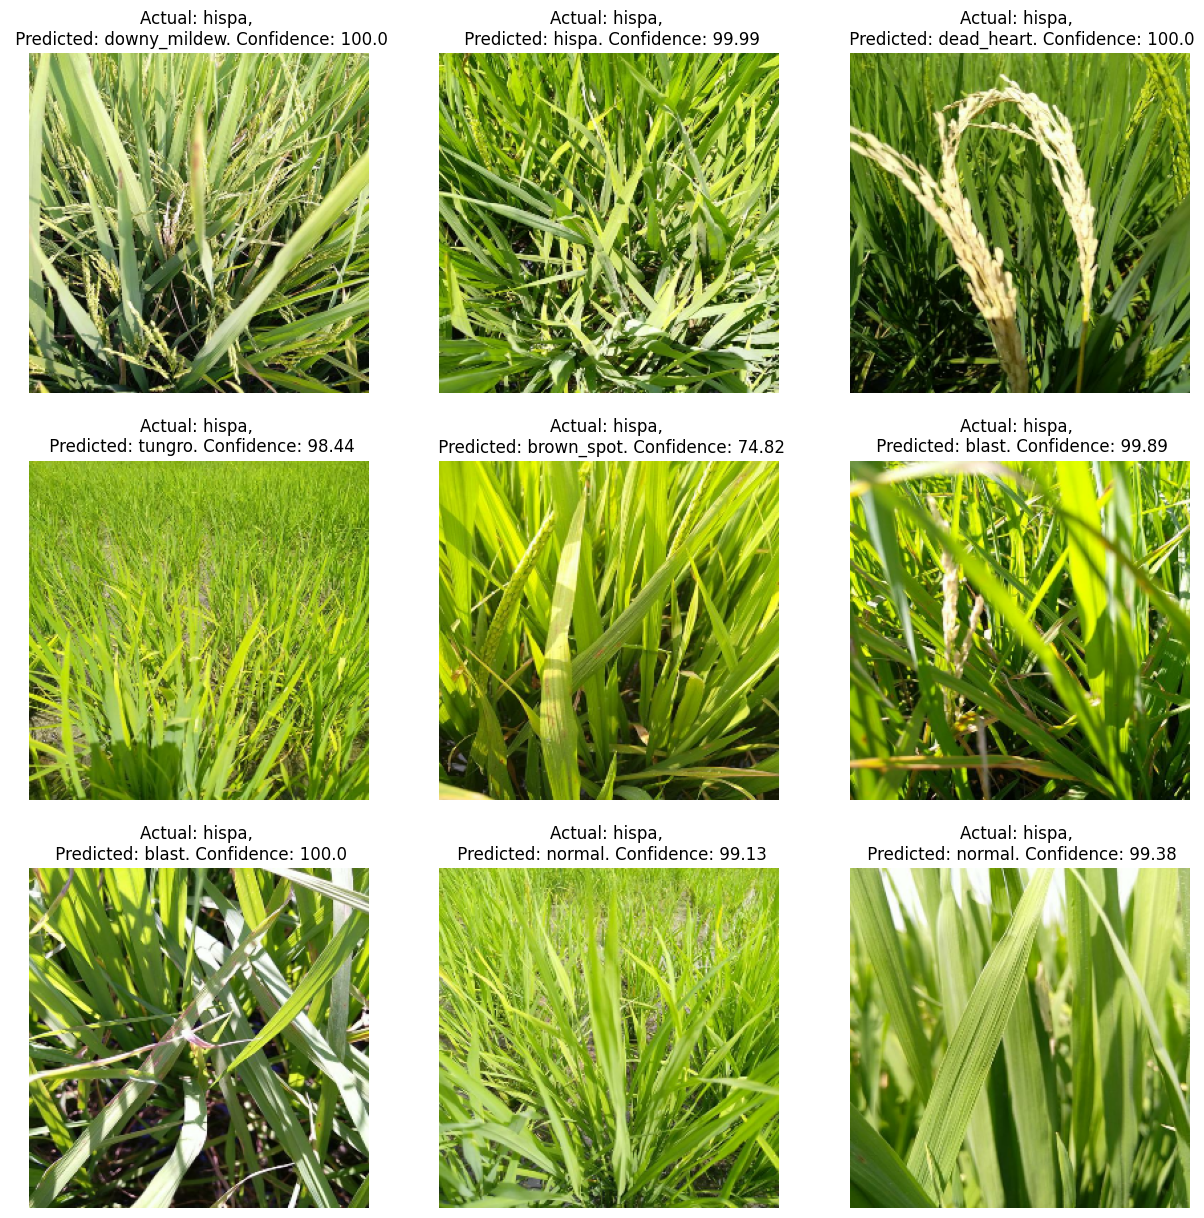

In [95]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[1]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. Confidence: {confidence}")
        plt.axis("off")

In [98]:
import os
model_version = max([int(i) for i in os.listdir("./models") + [0]]) + 1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/2\assets


INFO:tensorflow:Assets written to: ./models/2\assets


settings.. Level 1 DFD**

**Figure 5: Level 1 DFD**

---